#### -- Achknowledgement

This notebook is built on top of the amazing work shared publically by original authors of the following two notebooks.

1. https://www.kaggle.com/code/vitalykudelya/enefit-object-oriented-gbdt
2. https://www.kaggle.com/code/siddhvr/enefit-pebop-eda-plotly-and-modelling?scriptVersionId=158496419

### New Additions and Modifications to above Notebooks

1. New Features Based on Domain Knowledge and Exploratory Data Analysis
2. Removal of less Important Features
3. New Model Ensembles
4. A Post Processing Function

### 1. Import Necessary Libraries

In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
import gc
import pickle
import datetime

import numpy as np
import pandas as pd
import polars as pl
from sklearn.ensemble import VotingRegressor
import lightgbm as lgb

import holidays

### 2. Create a Class to Store and Process all the Data Files

In [2]:
class DataStorage:
    root = "/kaggle/input/predict-energy-behavior-of-prosumers"

    data_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
        "row_id",
    ]
    client_cols = [
        "product_type",
        "county",
        "eic_count",
        "installed_capacity",
        "is_business",
        "date",
    ]
    gas_prices_cols = ["forecast_date", "lowest_price_per_mwh", "highest_price_per_mwh"]
    electricity_prices_cols = ["forecast_date", "euros_per_mwh"]
    forecast_weather_cols = [
        "latitude",
        "longitude",
        "hours_ahead",
        "temperature",
        "dewpoint",
        "cloudcover_high",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_total",
        "10_metre_u_wind_component",
        "10_metre_v_wind_component",
        "forecast_datetime",
        "direct_solar_radiation",
        "surface_solar_radiation_downwards",
        "snowfall",
        "total_precipitation",
    ]
    historical_weather_cols = [
        "datetime",
        "temperature",
        "dewpoint",
        "rain",
        "snowfall",
        "surface_pressure",
        "cloudcover_total",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_high",
        "windspeed_10m",
        "winddirection_10m",
        "shortwave_radiation",
        "direct_solar_radiation",
        "diffuse_radiation",
        "latitude",
        "longitude",
    ]
    location_cols = ["longitude", "latitude", "county"]
    target_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
    ]

    def __init__(self):
        self.df_data = pl.read_csv(
            os.path.join(self.root, "train.csv"),
            columns=self.data_cols,
            try_parse_dates=True,
        )
        self.df_client = pl.read_csv(
            os.path.join(self.root, "client.csv"),
            columns=self.client_cols,
            try_parse_dates=True,
        )
        self.df_gas_prices = pl.read_csv(
            os.path.join(self.root, "gas_prices.csv"),
            columns=self.gas_prices_cols,
            try_parse_dates=True,
        )
        self.df_electricity_prices = pl.read_csv(
            os.path.join(self.root, "electricity_prices.csv"),
            columns=self.electricity_prices_cols,
            try_parse_dates=True,
        )
        self.df_forecast_weather = pl.read_csv(
            os.path.join(self.root, "forecast_weather.csv"),
            columns=self.forecast_weather_cols,
            try_parse_dates=True,
        )
        self.df_historical_weather = pl.read_csv(
            os.path.join(self.root, "historical_weather.csv"),
            columns=self.historical_weather_cols,
            try_parse_dates=True,
        )
        self.df_weather_station_to_county_mapping = pl.read_csv(
            os.path.join(self.root, "weather_station_to_county_mapping.csv"),
            columns=self.location_cols,
            try_parse_dates=True,
        )
        self.df_data = self.df_data.filter(
            pl.col("datetime") >= pd.to_datetime("2022-01-01")
        )
        self.df_target = self.df_data.select(self.target_cols)

        self.schema_data = self.df_data.schema
        self.schema_client = self.df_client.schema
        self.schema_gas_prices = self.df_gas_prices.schema
        self.schema_electricity_prices = self.df_electricity_prices.schema
        self.schema_forecast_weather = self.df_forecast_weather.schema
        self.schema_historical_weather = self.df_historical_weather.schema
        self.schema_target = self.df_target.schema

        self.df_weather_station_to_county_mapping = (
            self.df_weather_station_to_county_mapping.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
        )

    def update_with_new_data(
        self,
        df_new_client,
        df_new_gas_prices,
        df_new_electricity_prices,
        df_new_forecast_weather,
        df_new_historical_weather,
        df_new_target,
    ):
        df_new_client = pl.from_pandas(
            df_new_client[self.client_cols], schema_overrides=self.schema_client
        )
        df_new_gas_prices = pl.from_pandas(
            df_new_gas_prices[self.gas_prices_cols],
            schema_overrides=self.schema_gas_prices,
        )
        df_new_electricity_prices = pl.from_pandas(
            df_new_electricity_prices[self.electricity_prices_cols],
            schema_overrides=self.schema_electricity_prices,
        )
        df_new_forecast_weather = pl.from_pandas(
            df_new_forecast_weather[self.forecast_weather_cols],
            schema_overrides=self.schema_forecast_weather,
        )
        df_new_historical_weather = pl.from_pandas(
            df_new_historical_weather[self.historical_weather_cols],
            schema_overrides=self.schema_historical_weather,
        )
        df_new_target = pl.from_pandas(
            df_new_target[self.target_cols], schema_overrides=self.schema_target
        )

        self.df_client = pl.concat([self.df_client, df_new_client]).unique(
            ["date", "county", "is_business", "product_type"]
        )
        self.df_gas_prices = pl.concat([self.df_gas_prices, df_new_gas_prices]).unique(
            ["forecast_date"]
        )
        self.df_electricity_prices = pl.concat(
            [self.df_electricity_prices, df_new_electricity_prices]
        ).unique(["forecast_date"])
        self.df_forecast_weather = pl.concat(
            [self.df_forecast_weather, df_new_forecast_weather]
        ).unique(["forecast_datetime", "latitude", "longitude", "hours_ahead"])
        self.df_historical_weather = pl.concat(
            [self.df_historical_weather, df_new_historical_weather]
        ).unique(["datetime", "latitude", "longitude"])
        self.df_target = pl.concat([self.df_target, df_new_target]).unique(
            ["datetime", "county", "is_business", "product_type", "is_consumption"]
        )

    def preprocess_test(self, df_test):
        df_test = df_test.rename(columns={"prediction_datetime": "datetime"})

        df_test = pl.from_pandas(
            df_test[self.data_cols[1:]], schema_overrides=self.schema_data
        )
        return df_test


### 3. Create Feature Enegineering Classes

The following feature engineering classes are responsible for carrying out feature engineering on dataframes provided during training and testing both. There are two different classes named $FeaturesGeneratorM3$ and $FeaturesGeneratorM4$ carrying out different feature engineering for two types of models used to bring in better diversity to the model ensemble. (I used earlier versions of feature engineering named $FeaturesGeneratorM1$ and $FeaturesGeneratorM2$, however they did not bring the expected performance gain, and therefore ommited)

The following are the modifications to the original feature engineering class.

1. FeaturesGeneratorM3

    Added $\_add\_secondary\_features$ function. 
    
    During the exploratory data analysis it was noted that the $target$ between $is\_consumption=0$ and $is\_consumption=1$ for the same $county$, $product\_type$ and $is\_business$, has a big correlation, which has not been taken into account within the original features. This can be seen in the figure below for two segments with same $county$, $product\_type$ and $is\_business$ but with $is\_consumption=0$ and $is\_consumption=1$.
    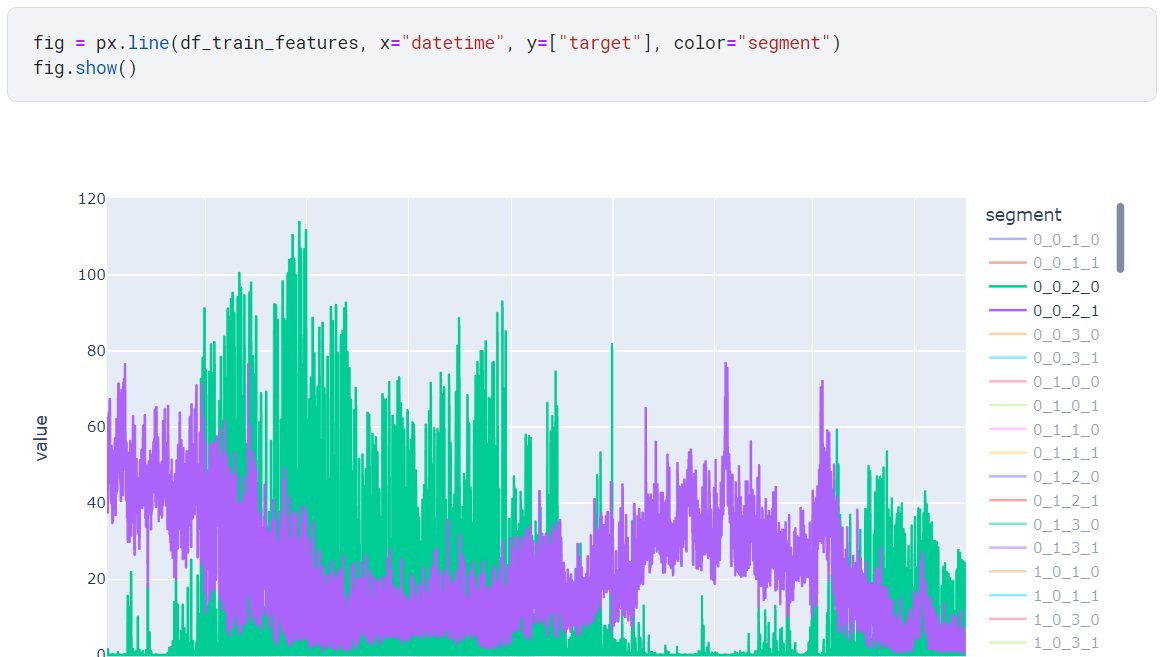

    For a particular segment, a complimentory segment is noted by taking the compliment of the variable $is\_consumption$ and $target\_mean$, $target\_std$ and lagged targets (denoted $target\_48$, $target\_72$ and so on) of the complimentory segment, are added as new features.

    It was also noted that original features employ lagged $target$ in periodes of $24h$ such as $target\_48$, $target\_72$ and so on. However, $target\_(48+1)$, $target\_(48+2)$ and so on may also carry information. Therefore, percentage change and differences between $target$ and $target\_(48+1)$, $target\_(48+2)$ up to $target\_(48+6)$ so on are also added as new features.

2. FeaturesGeneratorM4

    Apart from the features added in $FeaturesGeneratorM3$, the following feature is also added as an estimate target. This equation was developed based on the information available in various online sources regarding the energy production of solar panels.

    $estimated\_target = \frac{installed\_capacity}{1000} \times surface\_solar\_radiation\_downwards \times (1-cloudcover\_total) \times \left(1-0.005*(temperature - 25)\right)$

    In this equation, $\left(1-0.005*(temperature - 25)\right)$ relates to the temparature coefficient of a solar panel, in which the energy production reduces by $0.5\%$ for every Celcius above 25.

    The $estimated\_target$ feature is not used directly as a feature in the model that uses FeaturesGeneratorM4. It is used to transform the $target$, which will be discussed under the model below.



In [3]:
class FeaturesGeneratorM3:
    def __init__(self, data_storage):
        self.data_storage = data_storage
        self.estonian_holidays = list(
            holidays.country_holidays("EE", years=range(2021, 2026)).keys()
        )

    def _add_general_features(self, df_features):
        df_features = (
            df_features.with_columns(
                pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
                pl.col("datetime").dt.hour().alias("hour"),
                pl.col("datetime").dt.day().alias("day"),
                pl.col("datetime").dt.weekday().alias("weekday"),
                pl.col("datetime").dt.month().alias("month"),
                pl.col("datetime").dt.year().alias("year"),
            )
            .with_columns(
                pl.concat_str(
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    separator="_",
                ).alias("segment"),
            )
            .with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
                (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
                (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
            )
        )
        return df_features

    def _add_client_features(self, df_features):
        df_client = self.data_storage.df_client

        df_features = df_features.join(
            df_client.with_columns(
                (pl.col("date") + pl.duration(days=2)).cast(pl.Date)
            ),
            on=["county", "is_business", "product_type", "date"],
            how="left",
        )
        return df_features
    
    def is_country_holiday(self, row):
        return (
            datetime.date(row["year"], row["month"], row["day"])
            in self.estonian_holidays
        )

    def _add_holidays_features(self, df_features):
        df_features = df_features.with_columns(
            pl.struct(["year", "month", "day"])
            .apply(self.is_country_holiday)
            .alias("is_country_holiday")
        )
        return df_features

    def _add_forecast_weather_features(self, df_features):
        df_forecast_weather = self.data_storage.df_forecast_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_forecast_weather = (
            df_forecast_weather.rename({"forecast_datetime": "datetime"})
            .filter((pl.col("hours_ahead") >= 22) & pl.col("hours_ahead") <= 45)
            .drop("hours_ahead")
            .with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_forecast_weather_date = (
            df_forecast_weather.group_by("datetime").mean().drop("county")
        )

        df_forecast_weather_local = (
            df_forecast_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [0, 7 * 24]:
            df_features = df_features.join(
                df_forecast_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_forecast_{hours_lag}h",
            )
            df_features = df_features.join(
                df_forecast_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_forecast_local_{hours_lag}h",
            )

        return df_features

    def _add_historical_weather_features(self, df_features):
        df_historical_weather = self.data_storage.df_historical_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_historical_weather = (
            df_historical_weather.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_historical_weather_date = (
            df_historical_weather.group_by("datetime").mean().drop("county")
        )

        df_historical_weather_local = (
            df_historical_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [2 * 24, 7 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )
            df_features = df_features.join(
                df_historical_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_historical_local_{hours_lag}h",
            )

        for hours_lag in [1 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag),
                    pl.col("datetime").dt.hour().alias("hour"),
                )
                .filter(pl.col("hour") <= 10)
                .drop("hour"),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )

        return df_features

    def _add_target_features(self, df_features):
        df_target = self.data_storage.df_target

        df_target_all_type_sum = (
            df_target.group_by(["datetime", "county", "is_business", "is_consumption"])
            .sum()
            .drop("product_type")
        )

        df_target_all_county_type_sum = (
            df_target.group_by(["datetime", "is_business", "is_consumption"])
            .sum()
            .drop("product_type", "county")
        )

        for hours_lag in [
            2 * 24,
            3 * 24,
            4 * 24,
            5 * 24,
            6 * 24,
            7 * 24,
            8 * 24,
            9 * 24,
            10 * 24,
            11 * 24,
            12 * 24,
            13 * 24,
            14 * 24,
        ]:
            df_features = df_features.join(
                df_target.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_{hours_lag}h"}),
                on=[
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    "datetime",
                ],
                how="left",
            )

        for hours_lag in [2 * 24, 3 * 24, 7 * 24, 14 * 24]:
            df_features = df_features.join(
                df_target_all_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_type_sum_{hours_lag}h"}),
                on=["county", "is_business", "is_consumption", "datetime"],
                how="left",
            )

            df_features = df_features.join(
                df_target_all_county_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_county_type_sum_{hours_lag}h"}),
                on=["is_business", "is_consumption", "datetime"],
                how="left",
                suffix=f"_all_county_type_sum_{hours_lag}h",
            )

        cols_for_stats = [
            f"target_{hours_lag}h" for hours_lag in [2 * 24, 3 * 24, 4 * 24, 5 * 24]
        ]
        df_features = df_features.with_columns(
            df_features.select(cols_for_stats).mean(axis=1).alias(f"target_mean"),
            df_features.select(cols_for_stats)
            .transpose()
            .std()
            .transpose()
            .to_series()
            .alias(f"target_std"),
        )

        for target_prefix, lag_nominator, lag_denomonator in [
            ("target", 24 * 7, 24 * 14),
            ("target", 24 * 2, 24 * 9),
            ("target", 24 * 3, 24 * 10),
            ("target", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 7, 24 * 14),
            ("target_all_county_type_sum", 24 * 2, 24 * 3),
            ("target_all_county_type_sum", 24 * 7, 24 * 14),
        ]:
            df_features = df_features.with_columns(
                (
                    pl.col(f"{target_prefix}_{lag_nominator}h")
                    / (pl.col(f"{target_prefix}_{lag_denomonator}h") + 1e-3)
                ).alias(f"{target_prefix}_ratio_{lag_nominator}_{lag_denomonator}")
            )

        return df_features
    
    def _add_secondary_features(self, df_features):
        compliment_cols = [
                           "county", 
                           "product_type", 
                           "is_business", 
                           "is_consumption", 
                           "datetime", 
                           "target_mean",
                           "target_std",
                           f"target_{2*24}h",
                           f"target_{3*24}h",
                           f"target_{4*24}h"
                          ]
        df_features = df_features.join(
            df_features.with_columns(
                (~pl.col("is_consumption").cast(pl.datatypes.Boolean)).cast(pl.Int64)
            ).select(compliment_cols),
            on=["county", "product_type", "is_business", "is_consumption", "datetime"],
            how="left",
            suffix=f"_compliment",
        )
        
        for hours_lag in [1,2,3,4,5,6]:
            df_features = df_features.with_columns(
                pl.col(f"target_{2*24}h").diff(hours_lag).over(["county", "product_type", "is_business", "is_consumption"]).alias(f"target_hourly_diff_{hours_lag}")
        
            )
            df_features = df_features.with_columns(
                pl.col(f"target_{2*24}h").pct_change(hours_lag).over(["county", "product_type", "is_business", "is_consumption"]).alias(f"target_hourly_pctchange_{hours_lag}")
        
            )
        
        return df_features

    def _reduce_memory_usage(self, df_features):
        df_features = df_features.with_columns(pl.col(pl.Float64).cast(pl.Float32))
        return df_features

    def _drop_columns(self, df_features):
        df_features = df_features.drop(
            "date", "datetime", "hour", "dayofyear"
        )
        
        #Drop columns with High NaN Values
        high_nan_cols = [
            "temperature_historical_24h",
            "dewpoint_historical_24h",
            "rain_historical_24h",
            "snowfall_historical_24h",
            "surface_pressure_historical_24h",
            "cloudcover_total_historical_24h",
            "cloudcover_low_historical_24h",
            "cloudcover_mid_historical_24h",
            "cloudcover_high_historical_24h",
            "windspeed_10m_historical_24h",
            "winddirection_10m_historical_24h",
            "shortwave_radiation_historical_24h",
            "direct_solar_radiation_historical_24h",
            "diffuse_radiation_historical_24h",
        ]
        df_features = df_features.drop(high_nan_cols)
        
        return df_features

    def _to_pandas(self, df_features, y):
        cat_cols = [
            "county",
            "is_business",
            "product_type",
            "is_consumption",
            "segment",
        ]

        if y is not None:
            df_features = pd.concat([df_features.to_pandas(), y.to_pandas()], axis=1)
        else:
            df_features = df_features.to_pandas()

        df_features = df_features.set_index("row_id")
        df_features[cat_cols] = df_features[cat_cols].astype("category")

        return df_features

    def generate_features(self, df_prediction_items):
        if "target" in df_prediction_items.columns:
            df_prediction_items, y = (
                df_prediction_items.drop("target"),
                df_prediction_items.select("target"),
            )
        else:
            y = None

        df_features = df_prediction_items.with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        )

        for add_features in [
            self._add_general_features,
            self._add_client_features,
            self._add_forecast_weather_features,
            self._add_historical_weather_features,
            self._add_target_features,
            self._add_holidays_features,
            self._add_secondary_features,
            self._reduce_memory_usage,
            self._drop_columns,
        ]:
            df_features = add_features(df_features)

        df_features = self._to_pandas(df_features, y)

        return df_features


In [4]:
class FeaturesGeneratorM4:
    def __init__(self, data_storage):
        self.data_storage = data_storage
        self.estonian_holidays = list(
            holidays.country_holidays("EE", years=range(2021, 2026)).keys()
        )

    def _add_general_features(self, df_features):
        df_features = (
            df_features.with_columns(
                pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
                pl.col("datetime").dt.hour().alias("hour"),
                pl.col("datetime").dt.day().alias("day"),
                pl.col("datetime").dt.weekday().alias("weekday"),
                pl.col("datetime").dt.month().alias("month"),
                pl.col("datetime").dt.year().alias("year"),
            )
            .with_columns(
                pl.concat_str(
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    separator="_",
                ).alias("segment"),
            )
            .with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
                (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
                (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
            )
        )
        return df_features

    def _add_client_features(self, df_features):
        df_client = self.data_storage.df_client

        df_features = df_features.join(
            df_client.with_columns(
                (pl.col("date") + pl.duration(days=2)).cast(pl.Date)
            ),
            on=["county", "is_business", "product_type", "date"],
            how="left",
        )
        return df_features
    
    def is_country_holiday(self, row):
        return (
            datetime.date(row["year"], row["month"], row["day"])
            in self.estonian_holidays
        )

    def _add_holidays_features(self, df_features):
        df_features = df_features.with_columns(
            pl.struct(["year", "month", "day"])
            .apply(self.is_country_holiday)
            .alias("is_country_holiday")
        )
        return df_features

    def _add_forecast_weather_features(self, df_features):
        df_forecast_weather = self.data_storage.df_forecast_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_forecast_weather = (
            df_forecast_weather.rename({"forecast_datetime": "datetime"})
            .filter((pl.col("hours_ahead") >= 22) & pl.col("hours_ahead") <= 45)
            .drop("hours_ahead")
            .with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_forecast_weather_date = (
            df_forecast_weather.group_by("datetime").mean().drop("county")
        )

        df_forecast_weather_local = (
            df_forecast_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [0, 7 * 24]:
            df_features = df_features.join(
                df_forecast_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_forecast_{hours_lag}h",
            )
            df_features = df_features.join(
                df_forecast_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_forecast_local_{hours_lag}h",
            )

        return df_features

    def _add_historical_weather_features(self, df_features):
        df_historical_weather = self.data_storage.df_historical_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_historical_weather = (
            df_historical_weather.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_historical_weather_date = (
            df_historical_weather.group_by("datetime").mean().drop("county")
        )

        df_historical_weather_local = (
            df_historical_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [2 * 24, 7 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )
            df_features = df_features.join(
                df_historical_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_historical_local_{hours_lag}h",
            )

        for hours_lag in [1 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag),
                    pl.col("datetime").dt.hour().alias("hour"),
                )
                .filter(pl.col("hour") <= 10)
                .drop("hour"),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )

        return df_features

    def _add_target_features(self, df_features):
        df_target = self.data_storage.df_target

        df_target_all_type_sum = (
            df_target.group_by(["datetime", "county", "is_business", "is_consumption"])
            .sum()
            .drop("product_type")
        )

        df_target_all_county_type_sum = (
            df_target.group_by(["datetime", "is_business", "is_consumption"])
            .sum()
            .drop("product_type", "county")
        )

        for hours_lag in [
            2 * 24,
            3 * 24,
            4 * 24,
            5 * 24,
            6 * 24,
            7 * 24,
            8 * 24,
            9 * 24,
            10 * 24,
            11 * 24,
            12 * 24,
            13 * 24,
            14 * 24,
        ]:
            df_features = df_features.join(
                df_target.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_{hours_lag}h"}),
                on=[
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    "datetime",
                ],
                how="left",
            )

        for hours_lag in [2 * 24, 3 * 24, 7 * 24, 14 * 24]:
            df_features = df_features.join(
                df_target_all_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_type_sum_{hours_lag}h"}),
                on=["county", "is_business", "is_consumption", "datetime"],
                how="left",
            )

            df_features = df_features.join(
                df_target_all_county_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_county_type_sum_{hours_lag}h"}),
                on=["is_business", "is_consumption", "datetime"],
                how="left",
                suffix=f"_all_county_type_sum_{hours_lag}h",
            )

        cols_for_stats = [
            f"target_{hours_lag}h" for hours_lag in [2 * 24, 3 * 24, 4 * 24, 5 * 24]
        ]
        df_features = df_features.with_columns(
            df_features.select(cols_for_stats).mean(axis=1).alias(f"target_mean"),
            df_features.select(cols_for_stats)
            .transpose()
            .std()
            .transpose()
            .to_series()
            .alias(f"target_std"),
        )

        for target_prefix, lag_nominator, lag_denomonator in [
            ("target", 24 * 7, 24 * 14),
            ("target", 24 * 2, 24 * 9),
            ("target", 24 * 3, 24 * 10),
            ("target", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 7, 24 * 14),
            ("target_all_county_type_sum", 24 * 2, 24 * 3),
            ("target_all_county_type_sum", 24 * 7, 24 * 14),
        ]:
            df_features = df_features.with_columns(
                (
                    pl.col(f"{target_prefix}_{lag_nominator}h")
                    / (pl.col(f"{target_prefix}_{lag_denomonator}h") + 1e-3)
                ).alias(f"{target_prefix}_ratio_{lag_nominator}_{lag_denomonator}")
            )

        return df_features
    
    def _add_secondary_features(self, df_features):
        compliment_cols = [
                           "county", 
                           "product_type", 
                           "is_business", 
                           "is_consumption", 
                           "datetime", 
                           "target_mean",
                           "target_std",
                           f"target_{2*24}h",
                           f"target_{3*24}h",
                           f"target_{4*24}h"
                          ]
        df_features = df_features.join(
            df_features.with_columns(
                (~pl.col("is_consumption").cast(pl.datatypes.Boolean)).cast(pl.Int64)
            ).select(compliment_cols),
            on=["county", "product_type", "is_business", "is_consumption", "datetime"],
            how="left",
            suffix=f"_compliment",
        )
        
        for hours_lag in [1,2,3,4,5,6]:
            df_features = df_features.with_columns(
                pl.col(f"target_{2*24}h").diff(hours_lag).over(["county", "product_type", "is_business", "is_consumption"]).alias(f"target_hourly_diff_{hours_lag}")
        
            )
            df_features = df_features.with_columns(
                pl.col(f"target_{2*24}h").pct_change(hours_lag).over(["county", "product_type", "is_business", "is_consumption"]).alias(f"target_hourly_pctchange_{hours_lag}")
        
            )
            
        df_features = (
            df_features.with_columns(
                ((pl.col("installed_capacity")/1000)*(pl.col("surface_solar_radiation_downwards"))*(1-pl.col("cloudcover_total"))*(1-0.005*(pl.col("temperature")-25))).alias("target_estimate1_generate")
            )
        )
        
        return df_features

    def _reduce_memory_usage(self, df_features):
        df_features = df_features.with_columns(pl.col(pl.Float64).cast(pl.Float32))
        return df_features

    def _drop_columns(self, df_features):
        df_features = df_features.drop(
            "date", "datetime", "hour", "dayofyear"
        )
        
        #Drop columns with High NaN Values
        high_nan_cols = [
            "temperature_historical_24h",
            "dewpoint_historical_24h",
            "rain_historical_24h",
            "snowfall_historical_24h",
            "surface_pressure_historical_24h",
            "cloudcover_total_historical_24h",
            "cloudcover_low_historical_24h",
            "cloudcover_mid_historical_24h",
            "cloudcover_high_historical_24h",
            "windspeed_10m_historical_24h",
            "winddirection_10m_historical_24h",
            "shortwave_radiation_historical_24h",
            "direct_solar_radiation_historical_24h",
            "diffuse_radiation_historical_24h",
        ]
        df_features = df_features.drop(high_nan_cols)
        
        return df_features

    def _to_pandas(self, df_features, y):
        cat_cols = [
            "county",
            "is_business",
            "product_type",
            "is_consumption",
            "segment",
        ]

        if y is not None:
            df_features = pd.concat([df_features.to_pandas(), y.to_pandas()], axis=1)
        else:
            df_features = df_features.to_pandas()

        df_features = df_features.set_index("row_id")
        df_features[cat_cols] = df_features[cat_cols].astype("category")

        return df_features

    def generate_features(self, df_prediction_items):
        if "target" in df_prediction_items.columns:
            df_prediction_items, y = (
                df_prediction_items.drop("target"),
                df_prediction_items.select("target"),
            )
        else:
            y = None

        df_features = df_prediction_items.with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        )

        for add_features in [
            self._add_general_features,
            self._add_client_features,
            self._add_forecast_weather_features,
            self._add_historical_weather_features,
            self._add_target_features,
            self._add_holidays_features,
            self._add_secondary_features,
            self._reduce_memory_usage,
            self._drop_columns,
        ]:
            df_features = add_features(df_features)

        df_features = self._to_pandas(df_features, y)

        return df_features

### 4. Initialisation

Instantiate DataStorage class the FeaturesGenerator classes defined above and carry out feature engineering for training data. Feature engineered training data is used not only for training but also during post-processing during the submission. 

In [5]:
data_storage = DataStorage()
features_generator_m3 = FeaturesGeneratorM3(data_storage=data_storage)
features_generator_m4 = FeaturesGeneratorM4(data_storage=data_storage)

df_train_features = features_generator_m3.generate_features(data_storage.df_data)
df_train_features = df_train_features[df_train_features['target'].notnull()]

### 5. Model Definitions

Four different types of LightGBM models are used in the overrall composite model ensemble.

1. Model_1

    This is the same model outlined in the public notebooks. The model employes two models for each group $is\_consumption=0$ and $is\_consumption=1$ and the model for each group is an ensemble of 10 LightGBMs initialized randomly. The models predicts and trains on the raw values of the $target$ for both $is\_consumption=0$ and $is\_consumption=1$.

2. Model

    This is also one of the models shared in one of the public notebooks, I acknowledged. The model employes two models for each group $is\_consumption=0$ and $is\_consumption=1$ and the model for each group is an ensemble of 14 LightGBMs initialized randomly. The models predicts and trains on the difference in the $target$ and $target\_48$ (target lagged by 2 days), which is available during the prediction time.

3. Model_TargetNorm

    This model is a new addition. The model employes two models for each group $is\_consumption=0$ and $is\_consumption=1$ and the model for each group is an ensemble of 14 LightGBMs initialized randomly. For the group $is\_consumption=0$, the models predicts and trains on the difference in the $target$ and $target\_48$ (target lagged by 2 days) normalized by the $installed\_capacity$. This intuition behind the normalizing (which has also been a topic of discussion in the forum) is that, for the energy production group given by $is\_consumption=0$, the target has an increasing trend. It is logical as the $installed\_capacity$ increases the energy production should also increase. For Tree based models, this increasing trend will raise issue as they can only accurately predict for an input within range it has seen during the training. Therefore, normalizing the target with $installed\_capacity$ may bring a work around this issue. For the group $is\_consumption=1$, the model predicts and trains on difference in the $target$ and $target\_48$.

4. Model_TargetNorm_DropGen

    This model is also a new addition. The model employes two models for each group $is\_consumption=0$ and $is\_consumption=1$ and the model for each group is an ensemble of 12 LightGBMs initialized randomly. (Since I ran out of GPU quota, I trained 3 ensembles of of 4 using CPU in parallel. Each of these 3 is named Model_TargetNorm_DropGen_rnd1, Model_TargetNorm_DropGen_rnd2 and Model_TargetNorm_DropGen_rnd3, where the only difference is in the model initialization). For the group $is\_consumption=0$, the models predicts and trains on the difference in the $target$ and $target\_48$ $estimated\_target$ feature developed in FeaturesGeneratorM4 class above. For the group $is\_consumption=1$, this feature carries noise and hence omitted. This model has to be input with features obtained through the class FeaturesGeneratorM4.

The overall model ensemble takes a weighted average of the predictions generated by each of the four models above. (How I obtained weights for the average is discussed in the submission section). Intuitivelym each of the model brings in a different perspective of how the target is predicted, which results in diversity and hence gives more stability to the overall model.

In [6]:
class Model_1:
    def __init__(self):
        self.model_parameters = {
            "n_estimators": 2500,
            "learning_rate": 0.06,
            "colsample_bytree": 0.9,
            "colsample_bynode": 0.6,
            "lambda_l1": 3.5,
            "lambda_l2": 1.5,
            "max_depth": 16,
            "num_leaves": 500,
            "min_data_in_leaf": 50,
            "objective": "regression_l1",
            "device": "gpu",
        }

        self.model_consumption = VotingRegressor(
            [
                (
                    f"consumption_lgb_{i}",
                    lgb.LGBMRegressor(**self.model_parameters, random_state=i+30),
                )
                for i in range(10)
            ]
        )
        self.model_production = VotingRegressor(
            [
                (
                    f"production_lgb_{i}",
                    lgb.LGBMRegressor(**self.model_parameters, random_state=i+30),
                )
                for i in range(10)
            ]
        )

    def fit(self, df_train_features):
        mask = df_train_features["is_consumption"] == 1
        self.model_consumption.fit(
            X=df_train_features[mask].drop(columns=["target"]),
            y=df_train_features[mask]["target"]
        )

        mask = df_train_features["is_consumption"] == 0
        self.model_production.fit(
            X=df_train_features[mask].drop(columns=["target"]),
            y=df_train_features[mask]["target"]
        )

    def predict(self, df_features):
        predictions = np.zeros(len(df_features))

        mask = df_features["is_consumption"] == 1
        predictions[mask.values] = np.clip(
            self.model_consumption.predict(df_features[mask]),
            0,
            np.inf,
        )

        mask = df_features["is_consumption"] == 0
        predictions[mask.values] = np.clip(
            self.model_production.predict(df_features[mask]),
            0,
            np.inf,
        )

        return predictions

In [7]:
class Model:
    def __init__(self):
        self.model_parameters = {
            "n_estimators": 2500,
            "learning_rate": 0.06,
            "colsample_bytree": 0.9,
            "colsample_bynode": 0.6,
            "lambda_l1": 3.5,
            "lambda_l2": 1.5,
            "max_depth": 16,
            "num_leaves": 500,
            "min_data_in_leaf": 50,
            "objective": "regression_l1",
            "device": "gpu",
        }

        self.model_consumption = VotingRegressor(
            [
                (
                    f"consumption_lgb_{i}",
                    lgb.LGBMRegressor(**self.model_parameters, random_state=i),
                )
                for i in range(14)
            ]
        )
        self.model_production = VotingRegressor(
            [
                (
                    f"production_lgb_{i}",
                    lgb.LGBMRegressor(**self.model_parameters, random_state=i),
                )
                for i in range(14)
            ]
        )

    def fit(self, df_train_features):
        mask = df_train_features["is_consumption"] == 1
        self.model_consumption.fit(
            X=df_train_features[mask].drop(columns=["target"]),
            y=df_train_features[mask]["target"]
            - df_train_features[mask]["target_48h"].fillna(0),
        )

        mask = df_train_features["is_consumption"] == 0
        self.model_production.fit(
            X=df_train_features[mask].drop(columns=["target"]),
            y=df_train_features[mask]["target"]
            - df_train_features[mask]["target_48h"].fillna(0),
        )

    def predict(self, df_features):
        predictions = np.zeros(len(df_features))

        mask = df_features["is_consumption"] == 1
        predictions[mask.values] = np.clip(
            df_features[mask]["target_48h"].fillna(0).values
            + self.model_consumption.predict(df_features[mask]),
            0,
            np.inf,
        )

        mask = df_features["is_consumption"] == 0
        predictions[mask.values] = np.clip(
            df_features[mask]["target_48h"].fillna(0).values
            + self.model_production.predict(df_features[mask]),
            0,
            np.inf,
        )

        return predictions


In [8]:
class Model_TargetNorm:
    def __init__(self):
        self.model_parameters = {
            "n_estimators": 2500,
            "learning_rate": 0.06,
            "colsample_bytree": 0.9,
            "colsample_bynode": 0.6,
            "lambda_l1": 3.5,
            "lambda_l2": 1.5,
            "max_depth": 16,
            "num_leaves": 500,
            "min_data_in_leaf": 50,
            "objective": "regression_l1",
            "device": "gpu",
        }

        self.model_consumption = VotingRegressor(
            [
                (
                    f"consumption_lgb_{i}",
                    lgb.LGBMRegressor(**self.model_parameters, random_state=i),
                )
                for i in range(14)
            ]
        )
        self.model_production = VotingRegressor(
            [
                (
                    f"production_lgb_{i}",
                    lgb.LGBMRegressor(**self.model_parameters, random_state=i),
                )
                for i in range(14)
            ]
        )

    def fit(self, df_train_features):
        mask = df_train_features["is_consumption"] == 1
        self.model_consumption.fit(
            X=df_train_features[mask].drop(columns=["target"]),
            y=df_train_features[mask]["target"]
            - df_train_features[mask]["target_48h"].fillna(0),
        )

        mask = df_train_features["is_consumption"] == 0
        self.model_production.fit(
            X=df_train_features[mask].drop(columns=["target"]),
            y=(df_train_features[mask]["target"]
            - df_train_features[mask]["target_48h"].fillna(0))/(df_train_features[mask]["installed_capacity"].fillna(1000)),
        )

    def predict(self, df_features):
        predictions = np.zeros(len(df_features))

        mask = df_features["is_consumption"] == 1
        predictions[mask.values] = np.clip(
            df_features[mask]["target_48h"].fillna(0).values
            + self.model_consumption.predict(df_features[mask]),
            0,
            np.inf,
        )

        mask = df_features["is_consumption"] == 0
        predictions[mask.values] = np.clip(
            df_features[mask]["target_48h"].fillna(0).values
            + self.model_production.predict(df_features[mask])*(df_features[mask]["installed_capacity"].fillna(1000)),
            0,
            np.inf,
        )

        return predictions

In [9]:
class Model_TargetNorm_DropGen_rnd1:
    def __init__(self):
        self.model_parameters = {
            "n_estimators": 2500,
            "learning_rate": 0.06,
            "colsample_bytree": 0.9,
            "colsample_bynode": 0.6,
            "lambda_l1": 3.5,
            "lambda_l2": 1.5,
            "max_depth": 16,
            "num_leaves": 500,
            "min_data_in_leaf": 50,
            "objective": "regression_l1",
            #"device": "gpu",
        }

        self.model_consumption = VotingRegressor(
            [
                (
                    f"consumption_lgb_{i}",
                    lgb.LGBMRegressor(**self.model_parameters, random_state=i),
                )
                for i in range(4)
            ]
        )
        self.model_production = VotingRegressor(
            [
                (
                    f"production_lgb_{i}",
                    lgb.LGBMRegressor(**self.model_parameters, random_state=i),
                )
                for i in range(4)
            ]
        )

    def fit(self, df_train_features):
        mask = df_train_features["is_consumption"] == 1
        self.model_consumption.fit(
            X=df_train_features[mask].drop(columns=["target","target_estimate1_generate"]),
            y=df_train_features[mask]["target"]
            - df_train_features[mask]["target_48h"].fillna(0),
        )

        mask = df_train_features["is_consumption"] == 0
        self.model_production.fit(
            X=df_train_features[mask].drop(columns=["target","target_estimate1_generate"]),
            y=(df_train_features[mask]["target"]
            - df_train_features[mask]["target_estimate1_generate"].fillna(0)),
        )

    def predict(self, df_features):
        predictions = np.zeros(len(df_features))

        mask = df_features["is_consumption"] == 1
        predictions[mask.values] = np.clip(
            df_features[mask]["target_48h"].fillna(0).values
            + self.model_consumption.predict(df_features[mask].drop(columns=["target_estimate1_generate"])),
            0,
            np.inf,
        )

        mask = df_features["is_consumption"] == 0
        predictions[mask.values] = np.clip(
            df_features[mask]["target_estimate1_generate"].fillna(0).values
            + self.model_production.predict(df_features[mask].drop(columns=["target_estimate1_generate"])),
            0,
            np.inf,
        )

        return predictions

In [10]:
class Model_TargetNorm_DropGen_rnd2:
    def __init__(self):
        self.model_parameters = {
            "n_estimators": 2500,
            "learning_rate": 0.06,
            "colsample_bytree": 0.9,
            "colsample_bynode": 0.6,
            "lambda_l1": 3.5,
            "lambda_l2": 1.5,
            "max_depth": 16,
            "num_leaves": 500,
            "min_data_in_leaf": 50,
            "objective": "regression_l1",
            #"device": "gpu",
        }

        self.model_consumption = VotingRegressor(
            [
                (
                    f"consumption_lgb_{i}",
                    lgb.LGBMRegressor(**self.model_parameters, random_state=4+i),
                )
                for i in range(4)
            ]
        )
        self.model_production = VotingRegressor(
            [
                (
                    f"production_lgb_{i}",
                    lgb.LGBMRegressor(**self.model_parameters, random_state=4+i),
                )
                for i in range(4)
            ]
        )

    def fit(self, df_train_features):
        mask = df_train_features["is_consumption"] == 1
        self.model_consumption.fit(
            X=df_train_features[mask].drop(columns=["target","target_estimate1_generate"]),
            y=df_train_features[mask]["target"]
            - df_train_features[mask]["target_48h"].fillna(0),
        )

        mask = df_train_features["is_consumption"] == 0
        self.model_production.fit(
            X=df_train_features[mask].drop(columns=["target","target_estimate1_generate"]),
            y=(df_train_features[mask]["target"]
            - df_train_features[mask]["target_estimate1_generate"].fillna(0)),
        )

    def predict(self, df_features):
        predictions = np.zeros(len(df_features))

        mask = df_features["is_consumption"] == 1
        predictions[mask.values] = np.clip(
            df_features[mask]["target_48h"].fillna(0).values
            + self.model_consumption.predict(df_features[mask].drop(columns=["target_estimate1_generate"])),
            0,
            np.inf,
        )

        mask = df_features["is_consumption"] == 0
        predictions[mask.values] = np.clip(
            df_features[mask]["target_estimate1_generate"].fillna(0).values
            + self.model_production.predict(df_features[mask].drop(columns=["target_estimate1_generate"])),
            0,
            np.inf,
        )

        return predictions

In [11]:
class Model_TargetNorm_DropGen_rnd3:
    def __init__(self):
        self.model_parameters = {
            "n_estimators": 2500,
            "learning_rate": 0.06,
            "colsample_bytree": 0.9,
            "colsample_bynode": 0.6,
            "lambda_l1": 3.5,
            "lambda_l2": 1.5,
            "max_depth": 16,
            "num_leaves": 500,
            "min_data_in_leaf": 50,
            "objective": "regression_l1",
            #"device": "gpu",
        }

        self.model_consumption = VotingRegressor(
            [
                (
                    f"consumption_lgb_{i}",
                    lgb.LGBMRegressor(**self.model_parameters, random_state=8+i),
                )
                for i in range(4)
            ]
        )
        self.model_production = VotingRegressor(
            [
                (
                    f"production_lgb_{i}",
                    lgb.LGBMRegressor(**self.model_parameters, random_state=8+i),
                )
                for i in range(4)
            ]
        )

    def fit(self, df_train_features):
        mask = df_train_features["is_consumption"] == 1
        self.model_consumption.fit(
            X=df_train_features[mask].drop(columns=["target","target_estimate1_generate"]),
            y=df_train_features[mask]["target"]
            - df_train_features[mask]["target_48h"].fillna(0),
        )

        mask = df_train_features["is_consumption"] == 0
        self.model_production.fit(
            X=df_train_features[mask].drop(columns=["target","target_estimate1_generate"]),
            y=(df_train_features[mask]["target"]
            - df_train_features[mask]["target_estimate1_generate"].fillna(0)),
        )

    def predict(self, df_features):
        predictions = np.zeros(len(df_features))

        mask = df_features["is_consumption"] == 1
        predictions[mask.values] = np.clip(
            df_features[mask]["target_48h"].fillna(0).values
            + self.model_consumption.predict(df_features[mask].drop(columns=["target_estimate1_generate"])),
            0,
            np.inf,
        )

        mask = df_features["is_consumption"] == 0
        predictions[mask.values] = np.clip(
            df_features[mask]["target_estimate1_generate"].fillna(0).values
            + self.model_production.predict(df_features[mask].drop(columns=["target_estimate1_generate"])),
            0,
            np.inf,
        )

        return predictions


### 6. Loading Trained Models

Each of the above models is trained seperately, then saved and uploaded as different Kaggle Datasets. In this submission notebook, those datasets wihch includes trained models are added and the models are loaded.

In [12]:
import pickle

model1_file_name = "/kaggle/input/enefit-model-est10-newfeatures/Enefit-Model-Est10-newFeature.pkl"
with open(model1_file_name, 'rb') as f:
      model1 = pickle.load(f)
print("Model_1 imported.")

model3_file_name = "/kaggle/input/enefit-model-est14-targetdiff-newfeatures/Enefit-Model-Est10-TargetDiff.pkl"
with open(model3_file_name, 'rb') as f:
      model3 = pickle.load(f)
print("Model_3 imported.")

model3_TargetNorm_file_name = "/kaggle/input/enefit-model-est14-targetdiff-newfeatures-tn/Enefit-Model-Est14-TargetNorm.pkl"
with open(model3_TargetNorm_file_name, 'rb') as f:
      model3_TargetNorm = pickle.load(f)
print("Model_3 imported.")

model4_TargetGen1_file_name = "/kaggle/input/enefit-model-est4-targetgen-newfeatures/Enefit-Model-Est10-TargetNorm-DropGen-rnd1.pkl"
with open(model4_TargetGen1_file_name, 'rb') as f:
      model4_TargetGen1 = pickle.load(f)
print("Model_4_1 imported.")

model4_TargetGen2_file_name = "/kaggle/input/enefit-model-est4-targetgen-newfeatures/Enefit-Model-Est10-TargetNorm-DropGen-rnd2.pkl"
with open(model4_TargetGen2_file_name, 'rb') as f:
      model4_TargetGen2 = pickle.load(f)
print("Model_4_2 imported.")

model4_TargetGen3_file_name = "/kaggle/input/enefit-model-est4-targetgen-newfeatures/Enefit-Model-Est10-TargetNorm-DropGen-rnd3.pkl"
with open(model4_TargetGen3_file_name, 'rb') as f:
      model4_TargetGen3 = pickle.load(f)
print("Model_4_1 imported.")
        
gc.collect()

Model_1 imported.
Model_3 imported.
Model_3 imported.
Model_4_1 imported.
Model_4_2 imported.
Model_4_1 imported.


0

### 7. Post-processing Function

The following post-processing function was useful for low performing models with high prediction varience, wihch gave me good performance gains. But for a high performing models it might not bring in a preformance gain. However, I used the same post-processing function for the final ensemble as well and did not have time to check the effect of it in terms of performance.

First, the rolling mean and the standard deviation of the target is calculated for each county for a window of 14 days. A standard deviation for the target prediction is assumed, which can be considered as a hyper-parameter that needs to be optimized.  Based on the rolling standard deviation of the past targets and the assumed standard deviation of the target prediction, the predicted target is pulled towards the rolling mean. This prohibits the models from predicting too extrem values away from the rolling target mean. For a good model we can set the standard deviation of the prediction close to zero and it gives a higher weight to the prediction, which results in post-processed target close to the model prediction. For a low performing models, the standard deviation of the prediction can be set to a large value, which makes the post-processed target close to the rolling mean.

This can be achived using the following equation, which is implemented in the function below.

$postprocessed \ prediction = \frac{rolling\_std \times predicted\_target + assumed\_prediction_std \times rolling\_mean}{rolling\_std + assumed\_prediction_std}$

In [13]:
df_county_summary = df_train_features.groupby("county")[["target"]].mean().reset_index()
df_county_summary = df_county_summary.rename(columns={"target": "target_mean_county"})
df_county_summary["target_std_county"] = df_train_features.groupby("county")["target"].std()

def post_process(model_prediction,df_features,df_county_summary):
    #fill NA values of target_mean and target_std columns with mean and std values of county
    df_features = df_features.merge(df_county_summary,how="left",on="county")
    target_lag_cols = [f"target_{d*24}h" for d in [2,3,4,5,6,7,8,9,10,11,12,13,14]]
    df_features["target_mean_13"] = np.mean(df_features[target_lag_cols],axis=1)
    df_features["target_std_13"]  = np.std(df_features[target_lag_cols],axis=1)
    df_features["target_mean_13"] = df_features["target_mean_13"].fillna(df_features["target_mean_county"])
    df_features["target_std_13"]  = df_features["target_std_13"].fillna(df_features["target_std_county"])
    df_features = df_features.drop(["target_mean_county","target_std_county"],axis=1)
    
    #post-process with target_mean and target_std
    predicted_target_std = 1.5
    df_features["predicted_y"] = model_prediction
    df_features["post_predicted_y"] = (df_features["target_std_13"]*df_features["predicted_y"] + predicted_target_std*df_features["target_mean_13"])/(predicted_target_std + df_features["target_std_13"])
    df_features["post_predicted_y"] = df_features["post_predicted_y"].fillna(df_features["predicted_y"])
    
    return df_features["post_predicted_y"].to_numpy()

### 8. Submit API

Suitable model weights for averaging was obtained sequencially. First models with class names Model_1 and Model were used and suitable weights were found the ensemble of the two models. Next, the model with class name Model_TargetNorm is added to the ensemble and suitable weights were found for the two-model ensemble and the new model. Weight for the fourth model was also found similarly.

In [14]:
import enefit

env = enefit.make_env()
iter_test = env.iter_test()

In [15]:
for (
    df_test, 
    df_new_target, 
    df_new_client, 
    df_new_historical_weather,
    df_new_forecast_weather, 
    df_new_electricity_prices, 
    df_new_gas_prices, 
    df_sample_prediction
) in iter_test:
    
    data_storage.update_with_new_data(
        df_new_client=df_new_client,
        df_new_gas_prices=df_new_gas_prices,
        df_new_electricity_prices=df_new_electricity_prices,
        df_new_forecast_weather=df_new_forecast_weather,
        df_new_historical_weather=df_new_historical_weather,
        df_new_target=df_new_target
    )
    
    #separately generate test features for each model and take a weighted average
    
    df_test = data_storage.preprocess_test(df_test)
    df_test_features_3 = features_generator_m3.generate_features(df_test)
    df_test_features_4 = features_generator_m4.generate_features(df_test)
    
    model1_prediction   = model1.predict(df_test_features_3).clip(0.)
    model3_prediction   = model3.predict(df_test_features_3).clip(0.)
    modelTN_prediction  = model3_TargetNorm.predict(df_test_features_3).clip(0.)
    modelTG1_Prediction = model4_TargetGen1.predict(df_test_features_4).clip(0.)
    modelTG2_Prediction = model4_TargetGen2.predict(df_test_features_4).clip(0.)
    modelTG3_Prediction = model4_TargetGen3.predict(df_test_features_4).clip(0.)
    
    ens_prediction = (
        (((0.45 * model1_prediction) + (0.55 * model3_prediction))*0.8 + (modelTN_prediction)*0.2)*0.8 +
        (modelTG1_Prediction*(1/3)+modelTG2_Prediction*(1/3)+modelTG3_Prediction*(1/3))*0.2
    )
    
    post_ens_prediction = post_process(ens_prediction,df_test_features_3,df_county_summary)
    df_sample_prediction["target"] = post_ens_prediction.clip(0.)
    
    env.predict(df_sample_prediction)
    gc.collect()

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
